In [2]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pdb
import matplotlib.pyplot as plt
import h5py    
import pandas as pd

#import sklearn


import seaborn as sns
print(sns.__version__)
#import plotly.express as px
from scipy.special import betaincinv
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


import astropy.units as u
from astropy.cosmology import Planck15  

0.12.2


In [3]:
data_path = "/Users/marchuertascompany/Documents/data/COSMOS-Web/"
cosmos_cat = pd.read_csv(data_path+"COSMOSWeb_master_v1.6.0-sersic+BD-em_cgs_LePhare_nodupl_nomulti_morph_F150W_F277W_F444W_morphflag_CIGALE.csv")

sfr_CIGALE = np.log10(cosmos_cat['bayes.sfh.sfr'].values)
mass_CIGALE = np.log10(cosmos_cat['bayes.stellar.m_star'].values)

cosmos_cat['sfr_CIGALE'] = sfr_CIGALE
cosmos_cat['mass_CIGALE'] = mass_CIGALE



/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_58269/3913875886.py:4: RuntimeWarning: divide by zero encountered in log10
  sfr_CIGALE = np.log10(cosmos_cat['bayes.sfh.sfr'].values)


In [58]:
def build_features(cosmos_cat,zbin,node_features):
    x = node_features['x']   # halo mass and concentration
    t = node_features['t']
    ra =   node_features['ra']
    dec = node_features['dec']
    sersic = node_features['sersic']
    bovert = node_features['bovert']
    morphology = node_features['morphology']

    x_updated=[]
    t_updated=[]
    ra_updated=[]
    dec_updated=[]
    sersic_updated=[]
    bovert_updated=[]
    morphology_updated=[]
    sel2_len_vec=[]
    print("current size: ", len(x))
    n_chunks = len(x)

    for x_data, t_data,ra_data,dec_data,sersic_data, bovert_data, morphology_data in zip(x,t,ra,dec,sersic,bovert, morphology):
        mass_last = x_data[-1,0]

        sel2 = cosmos_cat.query("sfr_CIGALE > -15 and RADIUS > 0  and mass_CIGALE>"+str(mass_last-1.5)+" and mass_CIGALE<"+str(mass_last+.5)+ " and LP_zPDF>"+str(zbin[0])+" and LP_zPDF<"+str(zbin[1]))
        size_sample = int(len(sel2)*0.3)
        sel2 = sel2.sample(n=size_sample)
        #print("sample size:",size_sample)
        #print("len selection",len(sel2))
        #sel2_len_vec.append(len(sel2))
        chunks=0
        for i in range(len(sel2)):
            #print(sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])
            # Append 'x_data' and 't_data' for the current galaxy in the second bin
            #if (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])>0.2 or (sel2.logM_50.values[i]-np.log10(2)-x_data[-1,0])<-2:
            #    continue

               
            new_entry  = [sel2['mass_CIGALE'].values[i],np.log10(Planck15.angular_diameter_distance(sel2.LP_zPDF.values[i]).value * np.deg2rad(sel2.RADIUS.values[i]) * 1e3),sel2['sfr_CIGALE'].values[i]]
            new_x = np.vstack([x_data, new_entry])

            new_entry = [1/(1+sel2.LP_zPDF.values[i]) ] 
            new_t = np.vstack([t_data,new_entry])

            new_entry = [sel2.RA_DETEC.values[i]] 
            new_ra = np.vstack([ra_data,new_entry])

            new_entry = [sel2.DEC_DETEC.values[i]] 
            new_dec = np.vstack([dec_data,new_entry])

            new_entry = [sel2.SERSIC.values[i]] 
            new_sersic = np.vstack([sersic_data,new_entry])

            new_entry = [sel2['B/T_F444'].values[i]] 
            new_bovert = np.vstack([bovert_data,new_entry])

            new_entry = [sel2['morph_flag_f444w'].values[i]] 
            new_morphology= np.vstack([morphology_data,new_entry])

            #pdb.set_trace()

            # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_x_mass = [float(value) for value,size in zip(new_x[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_size = [float(value) for value in (new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_sfr = [float(value) for value in (new_x[0:,2]) if value != b'-' and value != b'-inf']
            x_copy = np.column_stack([cleaned_x_mass, cleaned_x_size,cleaned_x_sfr])

            cleaned_t = [float(value) for value,size in zip(new_t[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_t = np.expand_dims(cleaned_t,1)

            cleaned_ra = [float(value) for value,size in zip(new_ra[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_ra = np.expand_dims(cleaned_ra,1)

            cleaned_dec = [float(value) for value,size in zip(new_dec[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_dec = np.expand_dims(cleaned_dec,1)

            cleaned_sersic = [float(value) for value,size in zip(new_sersic[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_sersic = np.expand_dims(cleaned_sersic,1)

            cleaned_bovert = [float(value) for value,size in zip(new_bovert[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_bovert = np.expand_dims(cleaned_bovert,1)

            cleaned_morphology = [float(value) for value,size in zip(new_morphology[0:,0],new_x[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_morphology = np.expand_dims(cleaned_morphology,1)

            x_updated.append(x_copy)
            t_updated.append(cleaned_t)
            ra_updated.append(cleaned_ra)
            dec_updated.append(cleaned_dec)
            sersic_updated.append(cleaned_sersic)
            bovert_updated.append(cleaned_bovert)
            morphology_updated.append(cleaned_morphology)
            chunks+=1

            #pdb.set_trace()
        sel2_len_vec.append(chunks)
        #print("lengths:",chunks,len(sel2))
        if (len(sel2)!=chunks):
            #pdb.set_trace()
            print('weird')
        #print()
      # Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
    node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x_updated], 't': [np.array(arr, dtype=np.float32) for arr in t_updated],'ra': [np.array(arr, dtype=np.float32) for arr in ra_updated],'dec': [np.array(arr, dtype=np.float32) for arr in dec_updated],'sersic': [np.array(arr, dtype=np.float32) for arr in sersic_updated],'bovert': [np.array(arr, dtype=np.float32) for arr in bovert_updated],'morphology': [np.array(arr, dtype=np.float32) for arr in morphology_updated]}
    #print("after features:", len(x_updated))
    return node_features, n_chunks, sel2_len_vec
           






def build_roots(cosmos_cat,mass_bin,nsamples=100,zbins=[0,0.5,1]):
    


    sel = cosmos_cat.query("sfr_CIGALE > -15 and RADIUS > 0  and mass_CIGALE>"+str(mass_bin[0])+" and mass_CIGALE<" + str(mass_bin[1])+" and LP_zPDF>"+str(zbins[0])+" and LP_zPDF<"+str(zbins[1]))
    if len(sel)<nsamples:
        sel = sel.sample(frac=1)
    else:
        sel = sel.sample(nsamples)
    n_chunks = len(sel)
    x = []
    t = []
    ravec=[]
    decvec=[]
    sersicvec=[]
    bovertvec=[]
    morphologyvec=[]
    len_sel2_vec=[]
    node_features = {'x': None, 't': None, 'ra': None, 'dec': None}
    for mass,z,re,ra,dec,SFR,sersic,bovert,morphology in zip(sel['mass_CIGALE'],sel.LP_zPDF,sel.RADIUS,sel.RA_DETEC,sel.DEC_DETEC,sel['sfr_CIGALE'],sel.SERSIC, sel['B/T_F444W'],sel['morph_flag_f444w']):

        x_data=np.zeros((2,3))
        t_data=np.zeros(2)
        ra_data = np.zeros(2)
        dec_data = np.zeros(2)
        sersic_data= np.zeros(2)
        bovert_data=np.zeros(2)
        morphology_data =np.zeros(2)
        
        x_data[0,0]=mass
        x_data[0,1]=Planck15.angular_diameter_distance(z).value * np.deg2rad(re) * 1e3
        x_data[0,2]=SFR
        t_data[0] = 1/(1+z) 

        ra_data[0] = ra
        dec_data[0] = dec
        sersic_data[0]=sersic
        bovert_data[0]=bovert
        morphology_data[0]=morphology 

        sel2 =  cosmos_cat.query(" mass_CIGALE > -15 and RADIUS > 0  and mass_CIGALE>"+str(mass-1.5)+ " and mass_CIGALE<"+str(mass+0.5)+" and LP_zPDF>"+str(zbins[1])+" and LP_zPDF<"+str(zbins[2]))
        sel2 = sel2.sample(frac=0.3)
        chunks=0
        
        for i in range(len(sel2)):
            #print(x_data[0,0])
            #print((sel2.logM_50.values[i]-np.log10(2)-x_data[0,0]))
            # Append 'x_data' and 't_data' for the current galaxy in the second bin
            #if (sel2.logM_50.values[i]-np.log10(2)-x_data[0,0])>0.2 or (sel2.logM_50.values[i]-np.log10(2)-x_data[0,0])<-2:
             #   continue

            #print('here')     
            x_data[1,0]=sel2['mass_CIGALE'].values[i]
            x_data[1,1]=Planck15.angular_diameter_distance(sel2.LP_zPDF.values[i]).value * np.deg2rad(sel2.RADIUS.values[i]) * 1e3
            x_data[1,2]=sel2['sfr_CIGALE'].values[i]
            t_data[1]=1/(1+sel2.LP_zPDF.values[i])  
            ra_data[1] = sel2.RA_DETEC.values[i]
            dec_data[1] =sel2.DEC_DETEC.values[i]
            sersic_data[1]=sel2.SERSIC.values[i]
            bovert_data[1]=sel2['B/T_F444W'].values[i]
            morphology_data[1]=sel2['morph_flag_f444w'].values[i]

            #print(ra_data)
            # Convert the 'x_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_x_mass = [float(value) for value,size in zip(x_data[0:,0],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_size = [float(value) for value in (x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_x_SFR = [float(value) for value in (x_data[0:,2]) if value != b'-' and value != b'-inf']
           
            if len(cleaned_x_SFR) != len(x_data):
                print('caution!')
            x_copy = np.column_stack([cleaned_x_mass, np.log10(cleaned_x_size),cleaned_x_SFR])
            #print(np.array(x_copy).shape)
            #cleaned_x = [float(value) for value in x_data[1:] if value != b'-' and value != b'-inf']
            # Convert the 't_data' to a list of floats while ignoring non-numeric and 'inf' values and skipping the first row
            cleaned_t = [float(value) for value,size in zip(t_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_t = np.expand_dims(cleaned_t,1)

            cleaned_ra = [float(value) for value,size in zip(ra_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_ra = np.expand_dims(cleaned_ra,1)
            

            cleaned_dec = [float(value) for value,size in zip(dec_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_dec = np.expand_dims(cleaned_dec,1)

            cleaned_sersic = [float(value) for value,size in zip(sersic_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_sersic = np.expand_dims(cleaned_sersic,1)

            cleaned_bovert = [float(value) for value,size in zip(bovert_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_bovert = np.expand_dims(cleaned_bovert,1)

            cleaned_morphology = [float(value) for value,size in zip(morphology_data[0:],x_data[0:,1]) if value != b'-' and value != b'-inf']
            cleaned_morphology = np.expand_dims(cleaned_morphology,1)
           
            # Append the cleaned 'x' and 't' data to their respective lists
            x.append(x_copy)
            t.append(cleaned_t)
            ravec.append(cleaned_ra)
            decvec.append(cleaned_dec)
            sersicvec.append(cleaned_sersic)
            bovertvec.append(cleaned_bovert)
            morphologyvec.append(cleaned_morphology)
            #print('x_copy:', x_copy.shape)
            chunks+=1
        len_sel2_vec.append(chunks)
        if (len(sel2)!=chunks):
            print('weird')
        #print("lengths:",chunks,len(sel2))



    

    # Store 'x_copy' and 't' data as lists of NumPy arrays in the 'node_features' dictionary
    node_features = {'x': [np.array(arr, dtype=np.float32) for arr in x], 't': [np.array(arr, dtype=np.float32) for arr in t],'ra': [np.array(arr, dtype=np.float32) for arr in ravec],'dec': [np.array(arr, dtype=np.float32) for arr in decvec],'sersic': [np.array(arr, dtype=np.float32) for arr in sersicvec],'bovert': [np.array(arr, dtype=np.float32) for arr in bovertvec],'morphology': [np.array(arr, dtype=np.float32) for arr in morphologyvec]}
   
    return node_features,n_chunks,len_sel2_vec

    

In [59]:


def get_maxlike_descendant(l_numpy,node_features, num_chunks,chunk_size,step=1):

    x=node_features['x']
    t=node_features['t']
    ra=node_features['ra']
    dec=node_features['dec']
    # Calculate the number of chunks
    
    
    x_sel=[]
    t_sel=[]
    ra_sel=[]
    dec_sel=[]
    if step>1:
        l_numpy = l_numpy[step-1::step]
    #num_chunks = len(l_numpy) // chunk_size    
    print(num_chunks)
    print(len(chunk_size))
    start_idx =0
    end_idx=0
    for i in range(num_chunks):
        if i==0:
            start_idx=0
        else:
            start_idx = end_idx
        
        end_idx += chunk_size[i]
        #print(start_idx,end_idx)
        chunk = l_numpy[start_idx:end_idx]

        # Find the maximum value and its position in the chunk
        max_value = np.max(chunk)
        max_position = np.argmax(chunk)
        if len([start_idx + max_position])>1:
            print('weird!')
            

        x_sel.append(x[start_idx + max_position])
        t_sel.append(t[start_idx + max_position])
        ra_sel.append(ra[start_idx + max_position])
        dec_sel.append(dec[start_idx + max_position])
        
    node_features_updated = {'x': [np.array(arr, dtype=np.float32) for arr in x_sel], 't': [np.array(arr, dtype=np.float32) for arr in t_sel],'ra': [np.array(arr, dtype=np.float32) for arr in ra_sel],'dec': [np.array(arr, dtype=np.float32) for arr in dec_sel]}
    #print("after max selection:", len(x_sel))
    return node_features_updated

In [6]:
import torch
from typing import Optional, Tuple
from torch import Tensor
def log_likelihood_obs(
        model: torch.nn.Module, batch: Tuple[Tensor],
        to_numpy: bool = True,  batch_size: int = 4096
    ):
    """ Sample trees using Recurrent-MAF model
    Parameters
    ----------
    model: torch.nn.Module
        Recurrent model
    roots: np.ndarray
        Root features
    times: np.ndarray
        Time features
    to_numpy: bool
        Whether to convert to numpy
    device: Optional
        Device to use
    batch_size: int

    Returns
    -------
    x: Union[Tensor, np.ndarray]
        Sampled trees
    """

    device ='cpu'
    model = model.to(device)

    #seq_len = len(roots)+1
    #mask = np.expand_dims(np.zeros(seq_len),axis=0)
    #mask = np.zeros((1, seq_len), dtype=np.bool)
    #mask[:, :seq_len] = True
    #t = np.concatenate((times, t_obs),axis=1)

    #x_tensor = torch.from_numpy(roots.astype('float32'))
    #y_tensor = torch.from_numpy(obs.astype('float32'))
    #t_tensor = torch.from_numpy(t.astype('float32'))
    #seq_len_tensor = torch.tensor(seq_len, dtype=torch.int32)
    #mask_tensor = torch.from_numpy(mask)

    #tensor_tuple = (x_tensor, y_tensor, t_tensor, seq_len_tensor, mask_tensor)

    lp=model.log_prob(batch,return_context=False)

   
    return lp

In [7]:
# Load the trained model from a checkpoint file
from florah.models.rnn_model.rnn_generator import DataModule 
checkpoint_path = "/Users/marchuertascompany/Documents/data/CEERS/TNG100/SFR_simba.ckpt"  # Specify the path to your checkpoint file
loaded_model = DataModule.load_from_checkpoint(checkpoint_path,map_location='cpu')

# Set the model to evaluation mode (important if you have dropout or batch normalization layers)
loaded_model.eval()

DataModule(
  (model): RecurrentMAF(
    (embedding_net): Identity()
    (rnn): ModuleList(
      (0): GRU(5, 128, batch_first=True)
      (1-3): 3 x GRU(128, 128, batch_first=True)
    )
    (maf_blocks): Flow(
      (_transform): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0-3): 4 x CompositeTransform(
                (_transforms): ModuleList(
                  (0): MaskedAffineAutoregressiveTransform(
                    (autoregressive_net): MADE(
                      (initial_layer): MaskedLinear(in_features=3, out_features=128, bias=True)
                      (context_layer): Linear(in_features=128, out_features=128, bias=True)
                      (blocks): ModuleList(
                        (0-1): 2 x MaskedFeedforwardBlock(
                          (batch_norm): BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                          (line

In [61]:
import pickle
#redshifts = np.array([1.5,2,2.5,3,4,6])
redshifts = np.array([1.,1.5,2,2.5,3.5,4.5,6])


mass_bin = [[10,10.3],[10.3,10.6],[10.6,10.9],[11,12]]
for m in mass_bin:
    node_features,n_chunks, chunk_size = build_roots(cosmos_cat,m,nsamples=50)
    preprocessed_node_features = loaded_model.transform(node_features, fit=False)
    l  = log_likelihood_obs(loaded_model,preprocessed_node_features)
    l_numpy = l.detach().numpy()
    node_features = get_maxlike_descendant(l.detach().numpy(),node_features,n_chunks,chunk_size)

    step=2
    for zmin,zmax in zip(redshifts[:-1],redshifts[1:]):
        print(zmin,zmax)
        node_features,n_chunks,chunk_size = build_features(cosmos_cat,[zmin,zmax],node_features)
        preprocessed_node_features = loaded_model.transform(node_features, fit=False)
        l  = log_likelihood_obs(loaded_model,preprocessed_node_features)
        print('likelihood:', len(l.detach().numpy()))
        node_features = get_maxlike_descendant(l.detach().numpy(),node_features, n_chunks, chunk_size,step=step)
        step+=1
        
    # Store node_features
    with open(data_path+'node_features_morphology'+str(m[0])+'_'+str(m[1])+'.pkl', 'wb') as outfile:
        pickle.dump(node_features, outfile)

channel 3
(212556, 1, 3)
here [0]
done
50
50
1.0 1.5


KeyError: 'SERSIC'

In [19]:
output_path = '/Users/marchuertascompany/Documents/data/CEERS/TNG100/projenitors/SFR_simba/'
print(len(node_features['x']))
# Iterate through the entries in the structure
for i in range(len(node_features['x'])):
    df = pd.DataFrame({
        'x_mass': node_features['x'][i][:, 0],  # Assuming x_mass is the first column of x
        'x_size': node_features['x'][i][:, 1],  # Assuming x_size is the second column of x
        'x_SFR': node_features['x'][i][:, 2],  # Assuming x_sfr is the second column of x
        't': node_features['t'][i][:, 0],
        'ra': node_features['ra'][i][:, 0],
        'dec': node_features['dec'][i][:, 0]
    })

    # Get the values for constructing the file name
    ra_val = node_features['ra'][i][0][0]
    dec_val = node_features['dec'][i][0][0]

    # Construct the file name
    file_name = f"COSMOS_{ra_val}_{dec_val}.csv"

    # Save the DataFrame as a CSV file
    df.to_csv(output_path+file_name, index=False)

107


(51, 8, 3)


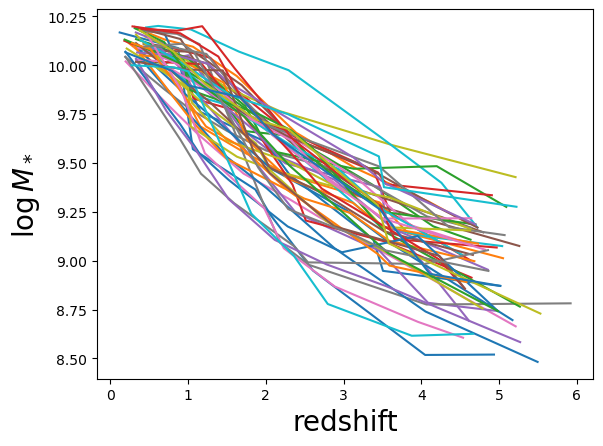

In [158]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(51):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,0]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log M_*$',fontsize=20)

plt.savefig('mass_growth_CEERS.png')

(22, 8, 3)


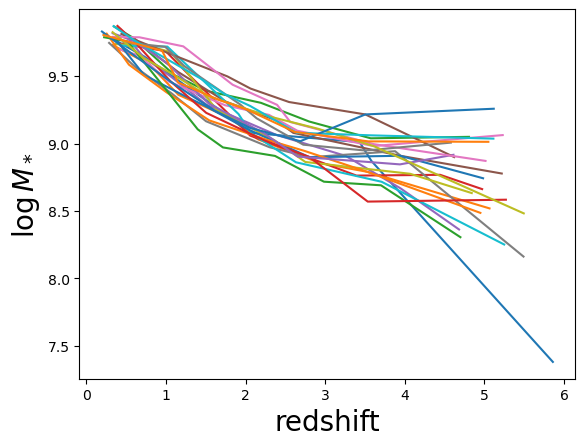

In [182]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(22):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,0]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log M_*$',fontsize=20)

plt.savefig('mass_growth_CEERS.png')

In [123]:
x_test = np.array(node_features['x'])
print((x_test[:,0,0]))

[10.556192 10.511621 10.612853 10.514433 10.544613 10.519187 10.67807
 10.636274 10.620914 10.502891 10.524202 10.621876 10.633491 10.507301]


(51, 8, 3)


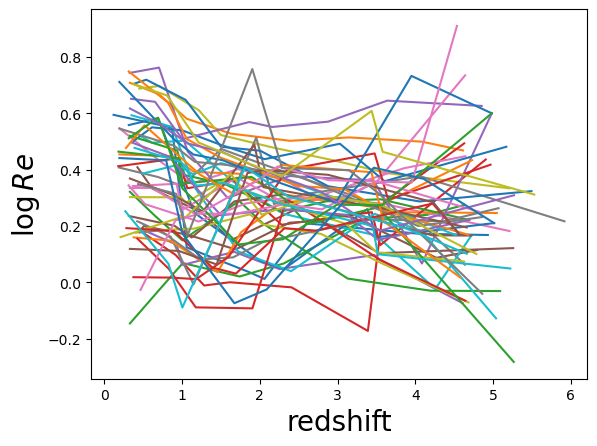

In [159]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(51):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,1]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log Re$',fontsize=20)

plt.savefig('re_growth_CEERS.png')

(22, 8, 3)


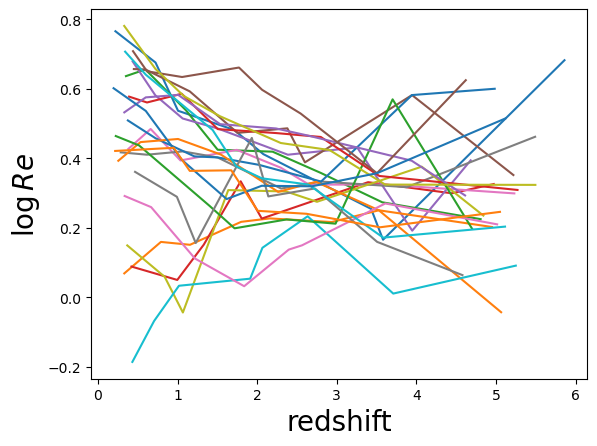

In [183]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(22):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,1]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log Re$',fontsize=20)

plt.savefig('re_growth_CEERS.png')

(51, 8, 3)


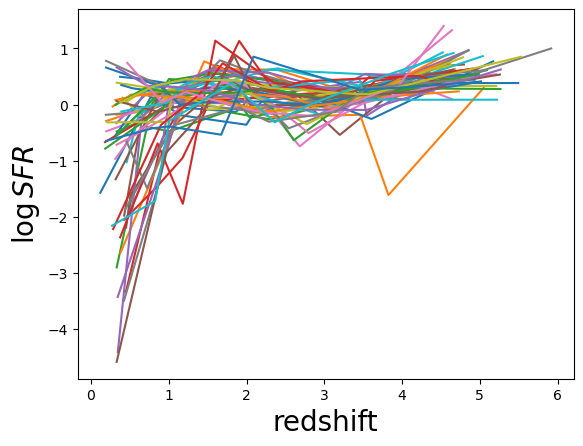

In [160]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(51):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,2]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)

plt.savefig('sfr_growth_CEERS.png')

Shapes: (176,) (176,)
[-0.86424742 -0.18770773 -0.02019646  0.00967866 -0.13699768 -0.21621139
  0.37847699  0.57274901]


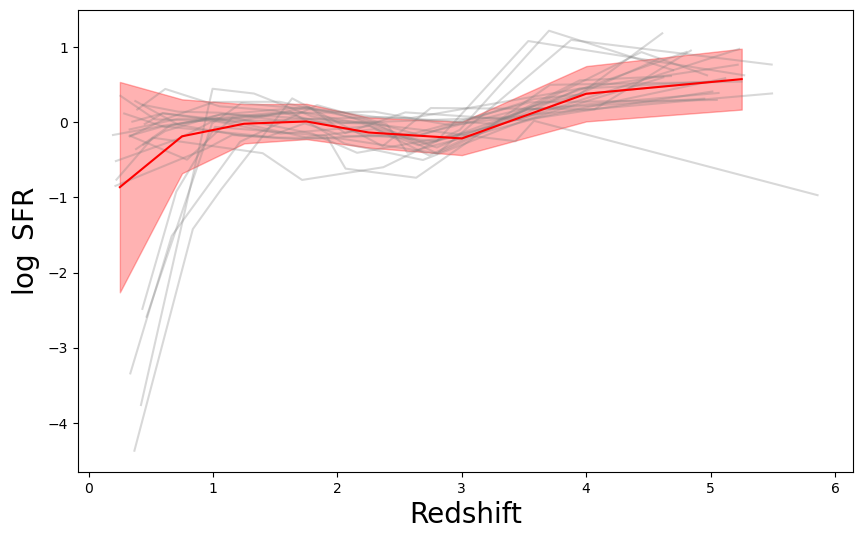

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

plt.figure(figsize=[10, 6])

all_sfrs = []
all_redshifts = []

for i in range(22):  # Assuming you have 51 entries based on your example
    redshifts = 1 / np.array(node_features['t'][i]) - 1
    sfr = np.array(node_features['x'][i][:, 2])
    plt.plot(redshifts, sfr, color='gray', alpha=0.3)

    all_redshifts.extend(redshifts)
    all_sfrs.extend(sfr)

# Make sure the data is in the correct numpy array format
all_redshifts_np = np.squeeze(np.array(all_redshifts))
all_sfrs_np = np.array(all_sfrs)

valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
filtered_redshifts = all_redshifts_np[valid_data_mask]
filtered_sfrs = all_sfrs_np[valid_data_mask]

# Verify shapes
print("Shapes:", all_redshifts_np.shape, all_sfrs_np.shape)

# Binning the data
bin_edges = np.array([0,0.5,1.,1.5,2,2.5,3.5,4.5,6])
bin_means, bin_edges, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=bin_edges)
bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=bin_edges)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.plot(bin_centers, bin_means, color='red')
print(bin_means)
plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color='red', alpha=0.3)

plt.xlabel('Redshift', fontsize=20)
plt.ylabel('$\log$ SFR', fontsize=20)

plt.savefig('sfr_growth_CEERS_modified.png')
plt.show()


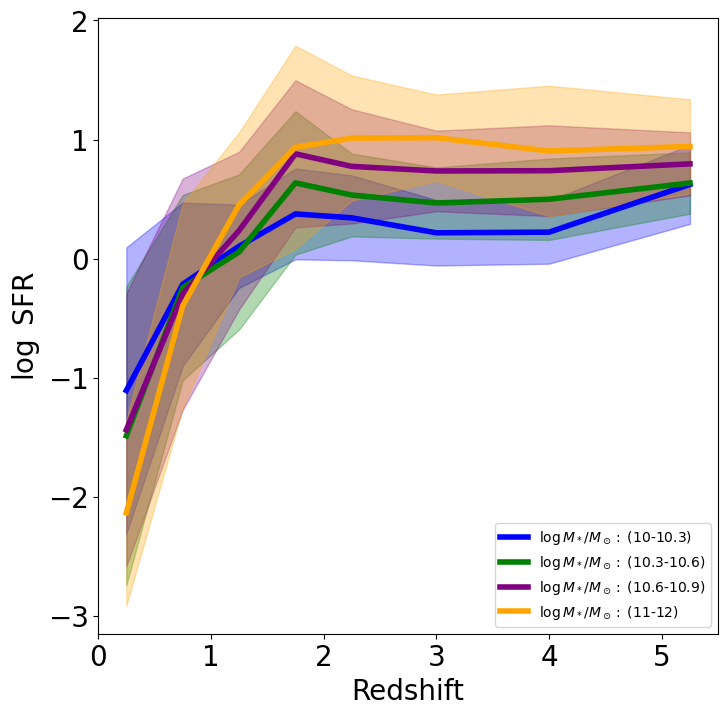

In [18]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(node_features['x'][i][:, 2])
        #plt.plot(redshifts, sfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(redshifts)
        all_sfrs.extend(sfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np[valid_data_mask]
    filtered_sfrs = all_sfrs_np[valid_data_mask]

    # Binning the data
    bin_means, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=bin_edges)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('$\log$ SFR', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


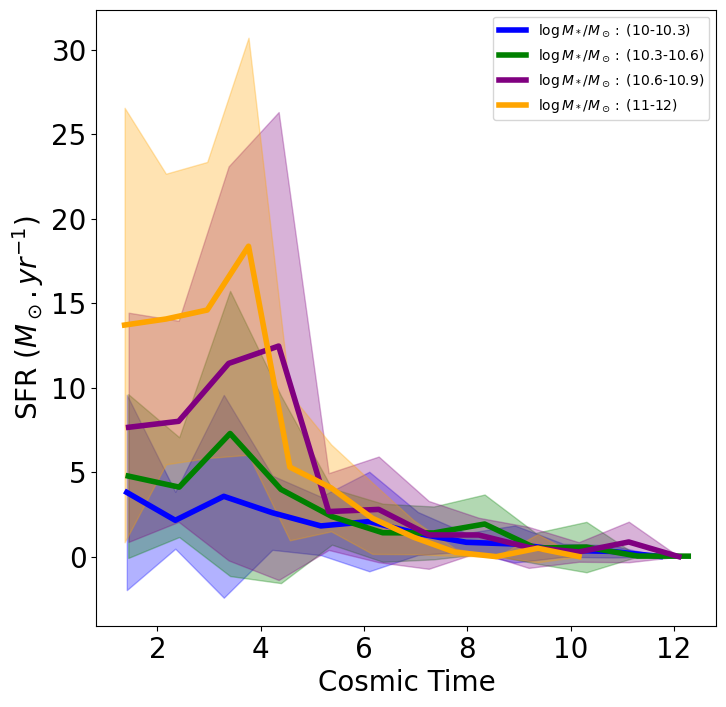

In [57]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from astropy.cosmology import Planck15

# Define your redshift bins and mass bins
nbins=12
bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []
   

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        t = np.array(node_features['t'][i])
        cosmic_times = Planck15.age(redshifts)
        sfr = 10**np.array(node_features['x'][i][:, 2])
        #plt.plot(redshifts, sfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(cosmic_times)
        all_sfrs.extend(sfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np[valid_data_mask]
    filtered_sfrs = all_sfrs_np[valid_data_mask]

    # Binning the data
    bin_means, bin_edges, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=nbins)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=nbins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('Cosmic Time', fontsize=20)
plt.ylabel('SFR ($M_\odot.yr^{-1}$)', fontsize=20)
plt.legend(loc='upper right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


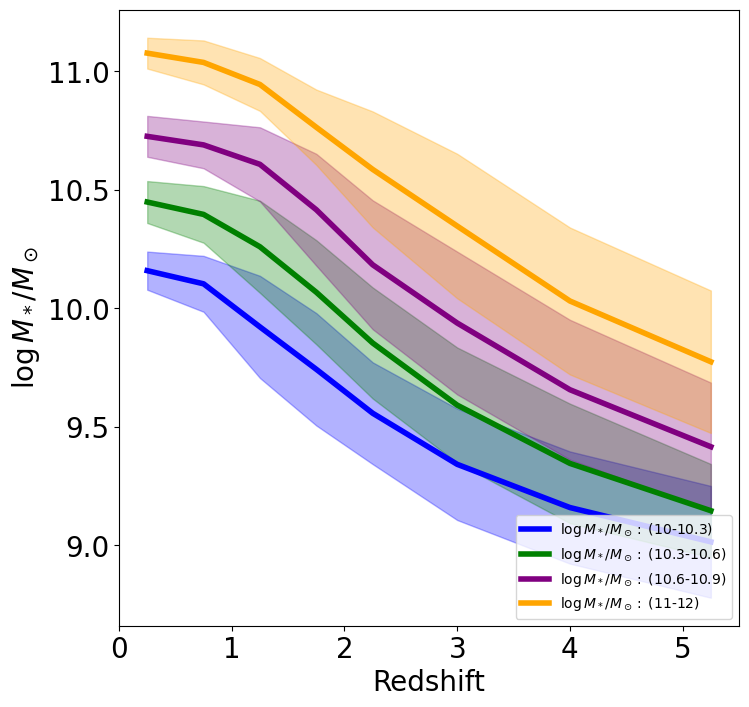

In [50]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(node_features['x'][i][:, 0])
        #plt.plot(redshifts, sfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(redshifts)
        all_sfrs.extend(sfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np[valid_data_mask]
    filtered_sfrs = all_sfrs_np[valid_data_mask]

    # Binning the data
    bin_means, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=bin_edges)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('$\log M_*/M_\odot$', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


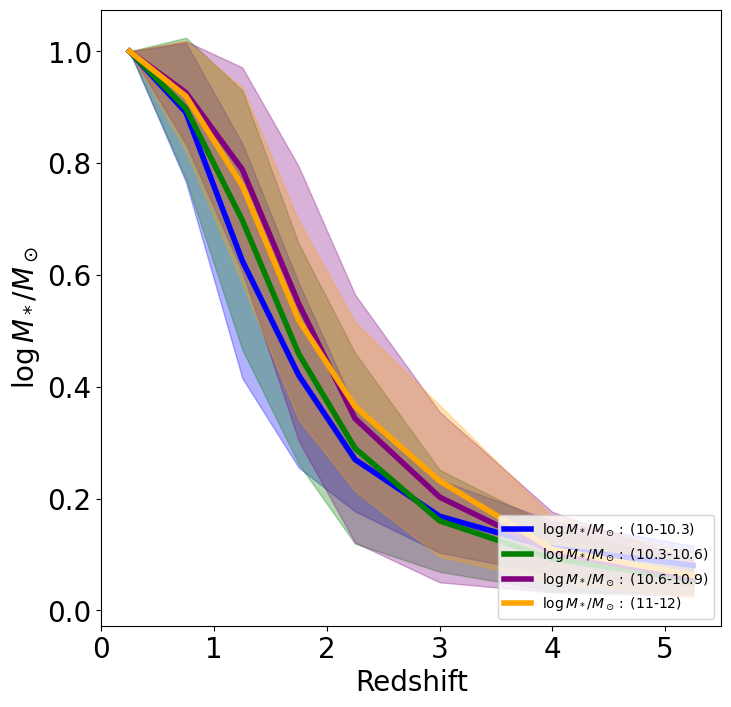

In [51]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(10**node_features['x'][i][:, 0]/10**node_features['x'][i][0, 0])
        #plt.plot(redshifts, sfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(redshifts)
        all_sfrs.extend(sfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np[valid_data_mask]
    filtered_sfrs = all_sfrs_np[valid_data_mask]

    # Binning the data
    bin_means, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=bin_edges)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('$\log M_*/M_\odot$', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


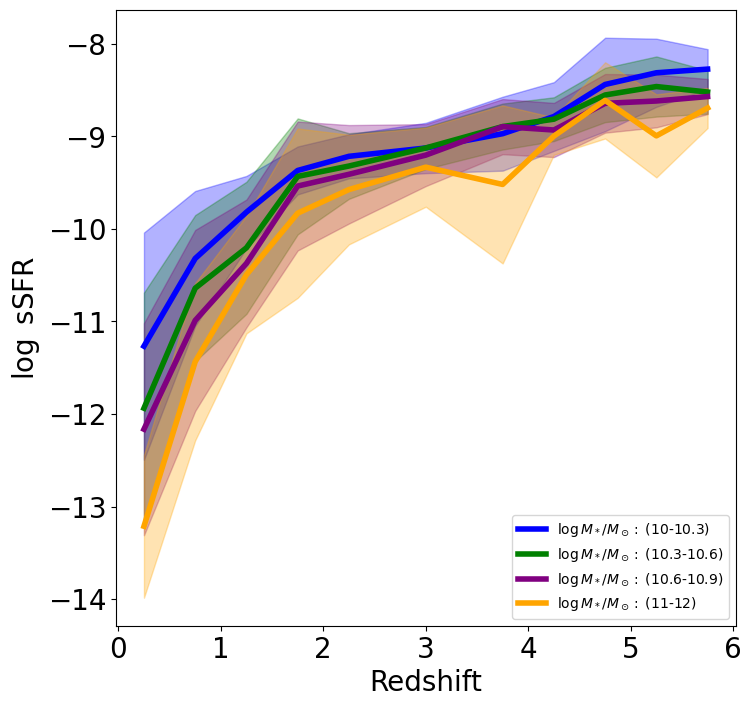

In [48]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5,4, 4.5,5,5.5, 6])
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(node_features['x'][i][:, 2])
        ssfr = np.log10(10**np.array(node_features['x'][i][:, 2])/10**np.array(node_features['x'][i][:, 0]))
        #plt.plot(redshifts, ssfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(redshifts)
        all_sfrs.extend(ssfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np #[valid_data_mask]
    filtered_sfrs = all_sfrs_np #[valid_data_mask]

    # Binning the data
    bin_means, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=bin_edges)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=bin_edges)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('$\log$ sSFR', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


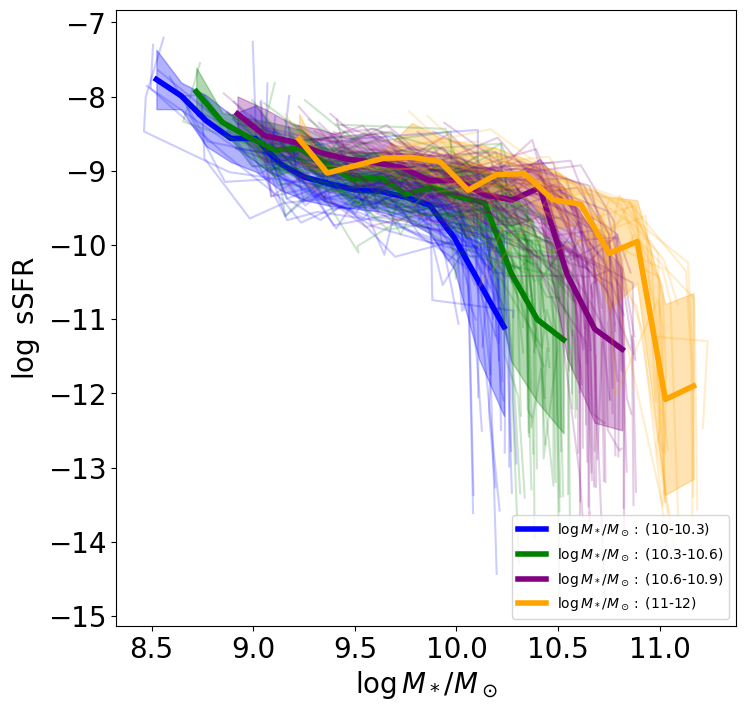

In [37]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
#bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
nbins = 15
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(node_features['x'][i][:, 2])
        mstar = np.array(node_features['x'][i][:, 0])
        ssfr = np.log10(10**np.array(node_features['x'][i][:, 2])/10**np.array(node_features['x'][i][:, 0]))
        plt.plot(mstar, ssfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(mstar)
        all_sfrs.extend(ssfr)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    #valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np
    filtered_sfrs = all_sfrs_np

    # Binning the data
    bin_means, bin_edges, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=nbins)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=nbins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('$\log M_*/M_\odot$', fontsize=20)
plt.ylabel('$\log$ sSFR', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


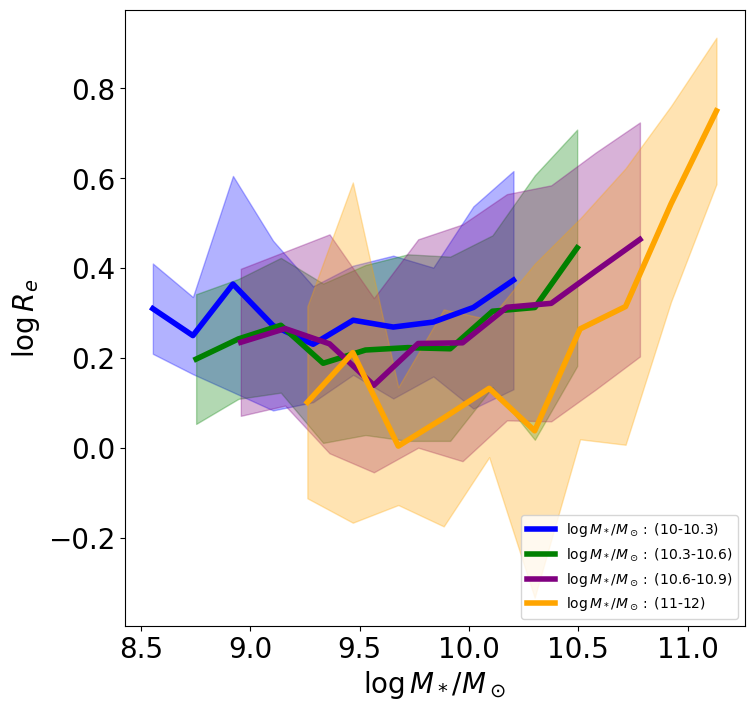

In [46]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Define your redshift bins and mass bins
#bin_edges = np.array([0, 0.5, 1., 1.5, 2, 2.5, 3.5, 4.5, 6])
nbins = 10
mass_bin = [[10, 10.3], [10.3, 10.6], [10.6, 10.9], [11, 12]]
colors = ['blue', 'green', 'purple', 'orange']  # Adjust or add more colors for each mass bin

plt.figure(figsize=[8, 8])
plt.tick_params(axis='both', which='major', labelsize=20)

# Loop through each mass bin and corresponding color
for m_bin, color in zip(mass_bin, colors):
    # Load node_features for the current mass bin
    with open(data_path+f'node_features_{m_bin[0]}_{m_bin[1]}.pkl', 'rb') as infile:
        node_features = pickle.load(infile)
        
    all_sfrs = []
    all_redshifts = []

    # Assuming 'n_chunks' is the total number of entries for node_features['t']
    for i in range(len(node_features['t'])):
        redshifts = 1 / np.array(node_features['t'][i]) - 1
        sfr = np.array(node_features['x'][i][:, 2])
        re = np.array(node_features['x'][i][:, 1])
        mstar = np.array(node_features['x'][i][:, 0])
        ssfr = np.log10(10**np.array(node_features['x'][i][:, 2])/10**np.array(node_features['x'][i][:, 0]))
        #plt.plot(mstar, ssfr, color=color, alpha=0.2)  # Use the same color for individual lines, with some alpha

        all_redshifts.extend(mstar)
        all_sfrs.extend(re)

    # Processing for binned statistics
    all_redshifts_np = np.squeeze(np.array(all_redshifts))
    all_sfrs_np = np.array(all_sfrs)

    # Filtering valid data
    #valid_data_mask = ~np.isnan(all_redshifts_np) & ~np.isnan(all_sfrs_np)
    filtered_redshifts = all_redshifts_np
    filtered_sfrs = all_sfrs_np

    # Binning the data
    bin_means, bin_edges, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='mean', bins=nbins)
    bin_stds, _, _ = stats.binned_statistic(filtered_redshifts, filtered_sfrs, statistic='std', bins=nbins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plotting mean and std deviation
    plt.plot(bin_centers, bin_means, color=color, label=f'$\log M_*/M_\odot:$ ({m_bin[0]}-{m_bin[1]})',lw=4)
    plt.fill_between(bin_centers, bin_means - bin_stds, bin_means + bin_stds, color=color, alpha=0.3)

# Finalizing the plot
plt.xlabel('$\log M_*/M_\odot$', fontsize=20)
plt.ylabel('$\log R_e$', fontsize=20)
plt.legend(loc='lower right')
plt.savefig('sfr_growth_CEERS_combined.png')
plt.show()


(22, 8, 3)


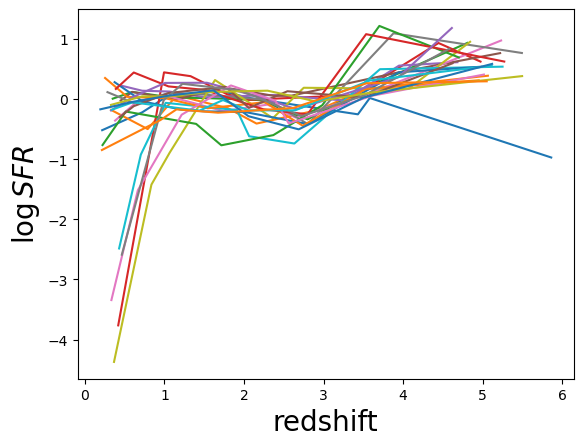

In [184]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(22):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,2]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)

plt.savefig('sfr_growth_CEERS.png')

(51, 8, 3)


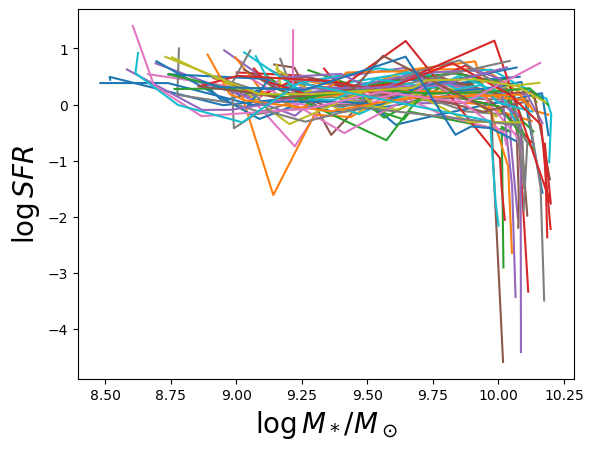

In [168]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(51):
    plt.plot(np.array(node_features['x'][i][:,0]),np.array(node_features['x'][i][:,2]))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)

#plt.savefig('sfr_growth_CEERS.png')

(22, 8, 3)


Text(0, 0.5, '$\\log SFR$')

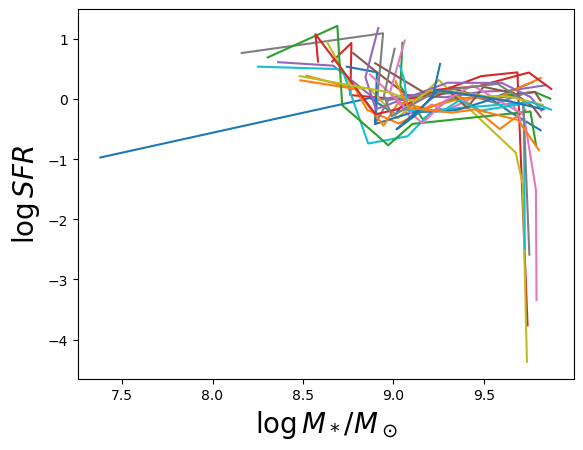

In [185]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(22):
    plt.plot(np.array(node_features['x'][i][:,0]),np.array(node_features['x'][i][:,2]))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)

#plt.savefig('sfr_growth_CEERS.png')

(51, 8, 3)


Text(0, 0.5, '$\\log sSFR$')

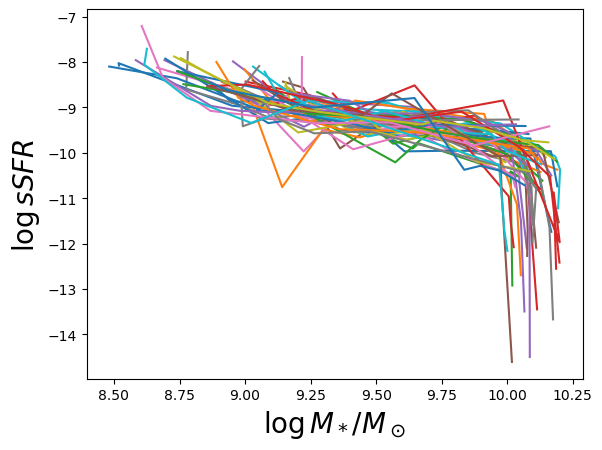

In [170]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(51):
    ssfr = np.log10(10**np.array(node_features['x'][i][:,2])/10**np.array(node_features['x'][i][:,0]))
    plt.plot(np.array(node_features['x'][i][:,0]),ssfr)

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log sSFR$',fontsize=20)

#plt.savefig('sfr_growth_CEERS.png')

(22, 8, 3)


Text(0, 0.5, '$\\log sSFR$')

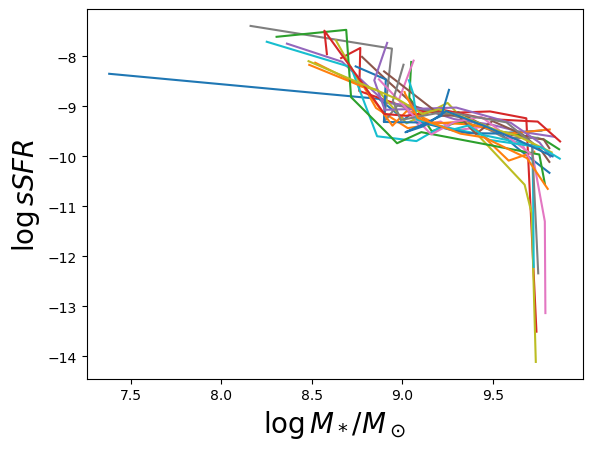

In [186]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(22):
    ssfr = np.log10(10**np.array(node_features['x'][i][:,2])/10**np.array(node_features['x'][i][:,0]))
    plt.plot(np.array(node_features['x'][i][:,0]),ssfr)

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log sSFR$',fontsize=20)

#plt.savefig('sfr_growth_CEERS.png')

(81, 8, 3)
214.88162
[52.88397]


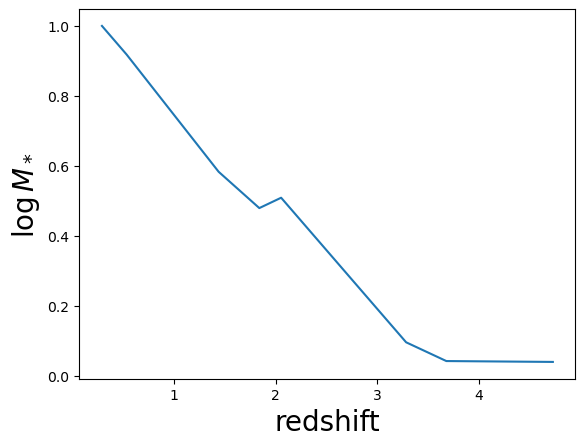

In [79]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(80):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,10**np.array(node_features['x'][i][:,0])/10**np.array(node_features['x'][i][0,0]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log M_*$',fontsize=20)


print(node_features['ra'][11][0][0])
print(node_features['dec'][11][0])

plt.savefig('mass_growth_CEERS.png')

In [80]:
q = cosmos_cat.query('RA_1>=214.88161 and RA_1<=214.88163 and DEC_1>=52.88396 and DEC_1<=52.88398')
q = cosmos_cat.query('RA_1>='+str(node_features['ra'][i][0][0]-1e-5)+' and RA_1<='+str(node_features['ra'][i][0][0]+1e-5)+' and DEC_1>='+str(node_features['dec'][i][0][0]-1e-5)+' and DEC_1<='+str(node_features['ra'][i][0][0]+1e-5))
#print(q.ID_1)

In [14]:
import os
from astropy.table import Table
densebasis_dir = '/Users/marchuertascompany/Documents/data/CEERS/DenseBasis/'
db_cat = pd.read_csv(densebasis_dir + "CEERS_v0.51_dense_basis.csv")



#os.listdir(densebasis_dir)
#db_cat = Table.read(densebasis_dir + "CEERS_v0.51_dense_basis.fits", format='ascii.commented_header')



<bound method FLRW.age of FlatLambdaCDM(name="Planck13", H0=67.77 km / (Mpc s), Om0=0.30712, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.048252)>
(81, 8, 3)


Text(0, 0.5, '$\\log SFR$')

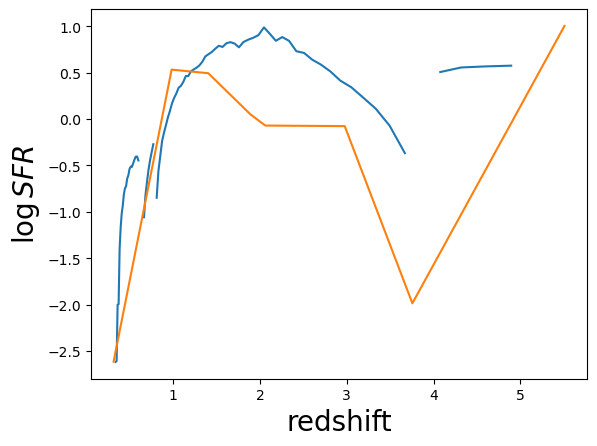

In [76]:
from astropy.cosmology import Planck13,z_at_value
import astropy.units as u

db_sel = db_cat.query('ID == 19566')
sfh=db_sel.sfh_50.values[0]
time = db_sel.timeax.values[0]

# Remove the parentheses and split the string by comma
sfh = sfh.strip('()').split(',')
time = time.strip('()').split(',')

# Convert the strings to float numbers
numbers = [float(num) for num in sfh]
numbers_time = [float(num) for num in time]

# Convert the list of numbers to a NumPy array
sfh_array = np.array(numbers)
time_array = np.array(numbers_time)



cosmo = Planck13

# Convert time to redshift
# Convert time to redshift

print(cosmo.age)

redshift_array = np.array([z_at_value(cosmo.age, (t) * u.Gyr) for t in time_array[1:]])

sfh_array = sfh_array[1:]
plt.plot(redshift_array[redshift_array<5],np.log10(sfh_array[redshift_array<5]))

print(np.array(node_features['x']).shape)
node_features['t'][0]


plt.plot(1/ np.array(node_features['t'][11]) - 1,np.array(node_features['x'][11][:,2]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)  

[84618]
[86845]
[90978]
[91282]
[93464]
[94704]
[94879]
[95915]
[97682]
[97803]


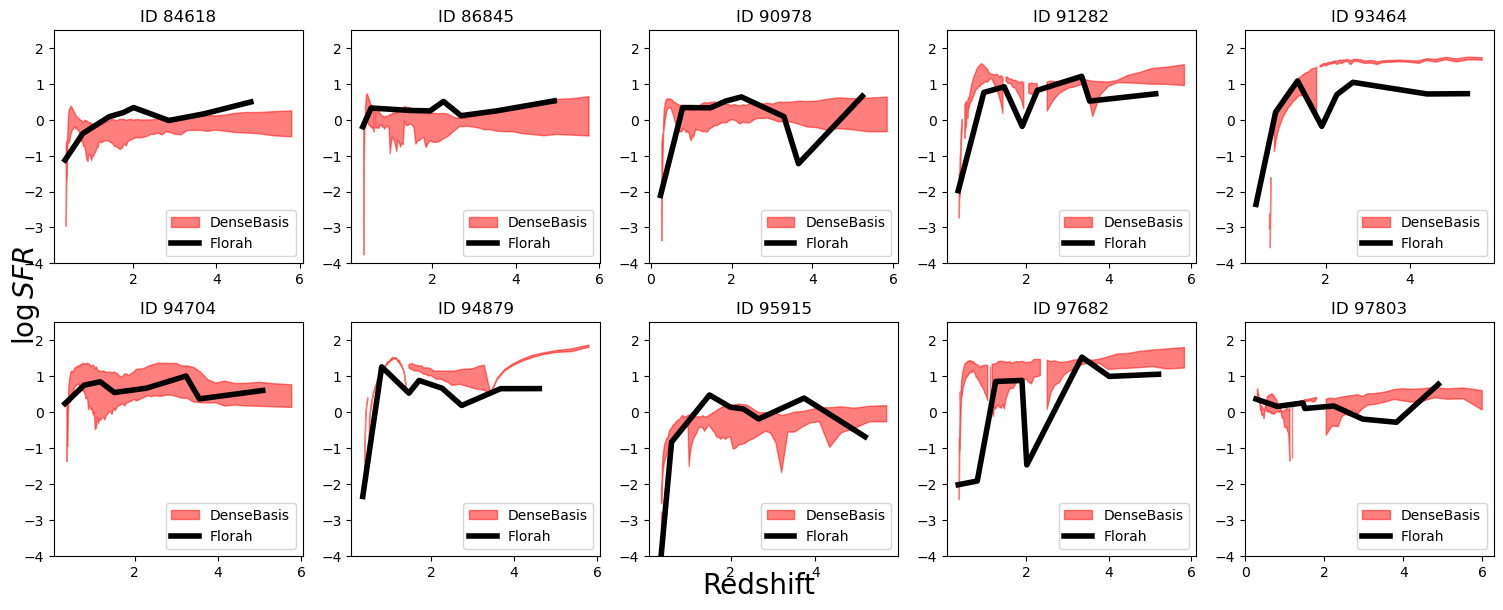

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
import astropy.units as u



# Create a 2x5 grid of subplots (10 panels)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

first_obj = 68

for i in range(10):
    q = cosmos_cat.query(
        'RA_1>=' + str(node_features['ra'][first_obj+i][0][0] - 1e-5) + ' and RA_1<=' + str(node_features['ra'][first_obj+i][0][0] + 1e-5) +
        ' and DEC_1>=' + str(node_features['dec'][first_obj+i][0][0] - 1e-5) + ' and DEC_1<=' + str(node_features['dec'][first_obj+i][0][0] + 1e-5))


    print(q['ID_1'].values)
    db_sel = db_cat.query('ID == ' + str(q['ID_1'].values[0]))
    sfh = db_sel.sfh_50.values[0]
    sfh_16 = db_sel.sfh_16.values[0]
    sfh_84 = db_sel.sfh_84.values[0]
    time = db_sel.timeax.values[0]

    # Remove the parentheses and split the string by comma
    sfh = sfh.strip('()').split(',')
    sfh_16 = sfh_16.strip('()').split(',')
    sfh_84 = sfh_84.strip('()').split(',')
    time = time.strip('()').split(',')

    # Convert the strings to float numbers
    numbers = [float(num) for num in sfh]
    numbers_16 = [float(num) for num in sfh_16]
    numbers_84 = [float(num) for num in sfh_84]
    numbers_time = [float(num) for num in time]

    # Convert the list of numbers to a NumPy array
    sfh_array = np.array(numbers)
    sfh_array_16 = np.array(numbers_16)
    sfh_array_84 = np.array(numbers_84)
    time_array = np.array(numbers_time)

    cosmo = Planck13

    # Convert time to redshift
    redshift_array = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in time_array[1:]])

    sfh_array = sfh_array[1:]
    #print(sfh_array[1:])
    sfh_array_16 = sfh_array_16[1:]
    sfh_array_84 = sfh_array_84[1:]

    # Determine the subplot location in the 2x5 grid
    row = i // 5
    col = i % 5

    # Plot the data on the current subplot
    #axs[row, col].plot(redshift_array[redshift_array < 5], np.log10(sfh_array[redshift_array < 5]))
    axs[row, col].fill_between(redshift_array[redshift_array < 6], np.log10(sfh_array_16[redshift_array < 6]),np.log10(sfh_array_84[redshift_array < 6]),color='red',alpha=0.5,label='DenseBasis')
    axs[row, col].set_title(f'ID '+str(q['ID_1'].values[0]))
    axs[row, col].plot(1/ np.array(node_features['t'][first_obj+i]) - 1,np.array(node_features['x'][first_obj+i][:,2]),lw=4,color='black',label='Florah')
    axs[row, col].legend(loc='lower right')
    axs[row, col].set_ylim((-4,2.5))
# Set common labels for the entire figure
fig.text(0.5, 0.001, 'Redshift', ha='center', fontsize=20)
fig.text(0.001, 0.5, '$\log SFR$', va='center', rotation='vertical', fontsize=20)

# Adjust subplot layout and show the figure
plt.tight_layout()
plt.savefig('SFH_comparisons.png')
plt.show()


In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

c = SkyCoord(ra=ra1*u.degree, dec=dec1*u.degree)

(81, 8, 3)


Text(0, 0.5, '$\\log R_e$')

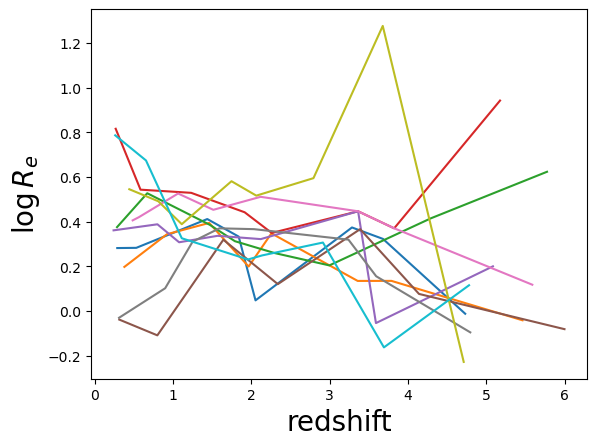

In [21]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(10):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,1]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log R_e$',fontsize=20)    

(81, 8, 3)


Text(0, 0.5, '$\\log SFR$')

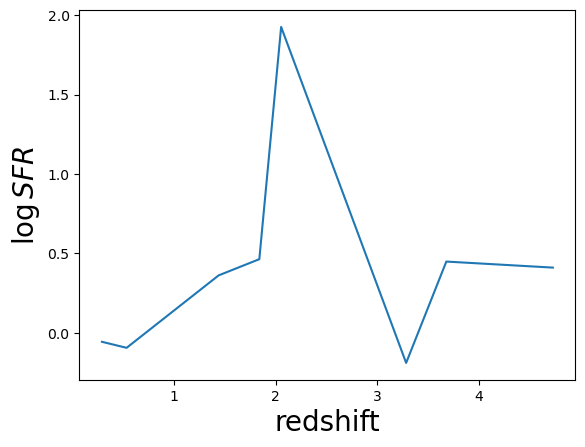

In [53]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(1):
    plt.plot(1/ np.array(node_features['t'][i]) - 1,np.array(node_features['x'][i][:,2]))

plt.xlabel('redshift',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)      

(81, 8, 3)


Text(0, 0.5, '$\\log SFR$')

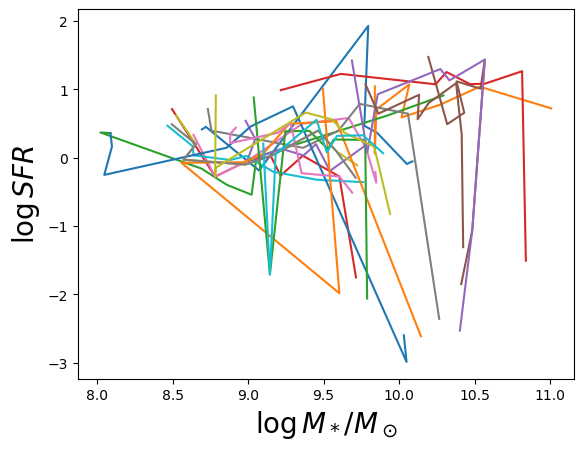

In [ ]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(20):
    plt.plot(np.array(node_features['x'][i][:,0]),np.array(node_features['x'][i][:,2]))

plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log SFR$',fontsize=20)    

(81, 8, 3)


Text(0, 0.5, '$\\log Re$')

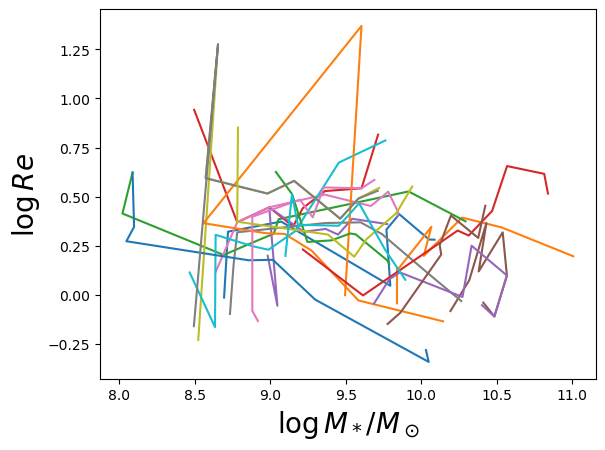

In [ ]:
print(np.array(node_features['x']).shape)
node_features['t'][0]

for i in range(20):
    plt.plot(np.array(node_features['x'][i][:,0]),np.array(node_features['x'][i][:,1]))


plt.xlabel('$\log M_*/M_\odot$',fontsize=20)

plt.ylabel('$\log Re$',fontsize=20)   